In [ ]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 5.6MB/s 
     |████████████████████████████████| 133kB 12.6MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 7.5MB 10.6MB/s 
ERROR: botocore 1.20.67 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from bert_utils import *

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


In [ ]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "data/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train. I'm going to name this 'gme'.
TASK_NAME = 'gme'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [ ]:
output_mode = OUTPUT_MODE

cache_dir = CACHE_DIR

In [ ]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [ ]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [ ]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)

In [ ]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache, downloading to /tmp/tmpb6g39ibg
100%|██████████| 213450/213450 [00:00<00:00, 395161.26B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpb6g39ibg to cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpb6g39ibg
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4

In [ ]:
label_map = {label: i for i, label in enumerate(label_list)}
print(label_map)
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

{'0': 0, '1': 1, '2': 2}


In [ ]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 960 examples..
Spawning 1 processes..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
with open(DATA_DIR + "train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz not found in cache, downloading to /tmp/tmpow4sc5cp
100%|██████████| 404400730/404400730 [00:34<00:00, 11655394.77B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpow4sc5cp to cache at cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpow4sc5cp
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [ ]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

In [ ]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [ ]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)

INFO:root:***** Running training *****
INFO:root:  Num examples = 960
INFO:root:  Batch size = 24
INFO:root:  Num steps = 400


In [ ]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
accuracy = []
matthews = []
f1 = []

model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        if OUTPUT_MODE == "classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif OUTPUT_MODE == "regression":
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_ids.view(-1))

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        #print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

    result = data_plotting(model)
    accuracy.append(result["accuracy"])
    matthews.append(result["mcc"])
    f1.append(result["f1"])









Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.3925233644859813
INFO:root:  task = gme
INFO:root:  mcc = 0.03390963410538245
INFO:root:  f1 = 0.3654443068677171
INFO:root:  eval_loss = 2.3745242059230804







Epoch:  10%|█         | 1/10 [00:17<02:33, 17.01s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.42990654205607476
INFO:root:  task = gme
INFO:root:  mcc = 0.030973832920639363
INFO:root:  f1 = 0.3526663001649258
INFO:root:  eval_loss = 2.627982407808304







Epoch:  20%|██        | 2/10 [00:33<02:15, 16.96s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.4205607476635514
INFO:root:  task = gme
INFO:root:  mcc = 0.07951945970979027
INFO:root:  f1 = 0.39310905485954295
INFO:root:  eval_loss = 2.6024148762226105







Epoch:  30%|███       | 3/10 [00:50<01:58, 16.91s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  40%|████      | 4/10 [01:07<01:41, 16.88s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  50%|█████     | 5/10 [01:24<01:24, 16.86s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  60%|██████    | 6/10 [01:41<01:07, 16.84s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  70%|███████   | 7/10 [01:57<00:50, 16.86s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  80%|████████  | 8/10 [02:14<00:33, 16.85s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch:  90%|█████████ | 9/10 [02:31<00:16, 16.84s/it]


107
107


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.38317757009345793
INFO:root:  task = gme
INFO:root:  mcc = 0.03310849114442136
INFO:root:  f1 = 0.3740674187904642
INFO:root:  eval_loss = 2.595089465379715







Epoch: 100%|██████████| 10/10 [02:48<00:00, 16.85s/it]


107
107


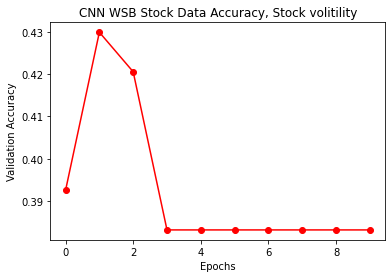

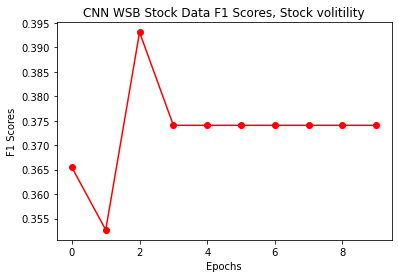

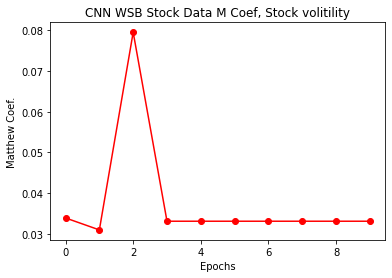

In [ ]:
import matplotlib.pyplot as plt

label_type = "volitility"

def plot_accuracy(accuracy_results, model_name):
    plt.figure()
    plt.plot(accuracy_results, 'ro-')
    plt.title(model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

def plot_scores(scores, model_name, label_name):
    plt.figure()
    plt.plot(scores, 'ro-')
    plt.title(model_name)
    plt.xlabel("Epochs")
    plt.ylabel(label_name)
    plt.show()


plot_accuracy(accuracy, "CNN WSB Stock Data Accuracy, Stock " + label_type)
plot_scores(f1, "CNN WSB Stock Data F1 Scores, Stock " + label_type, "F1 Scores")
plot_scores(matthews, "CNN WSB Stock Data M Coef, Stock " + label_type, "Matthew Coef.")
np.save("results/BERT-sentiment-accuracy-wsb-stock-" + label_type + ".npy", np.array(accuracy))
np.save("results/BERT-sentiment-f1-wsb-stock-" + label_type + ".npy", np.array(f1))
np.save("results/BERT-sentiment-m_coef-wsb-stock-" + label_type + ".npy", np.array(matthews))

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(OUTPUT_DIR)

'outputs/gme/vocab.txt'

#EVAL

In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, f1_score

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from torch.nn import CrossEntropyLoss, MSELoss

import numpy as np

In [ ]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "data/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'gme.tar.gz'

# The name of the task to train.I'm going to name this 'gme'.
TASK_NAME = 'gme'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_reports/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [ ]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [ ]:
def get_eval_report(task_name, labels, preds):
    num_correct = float((preds == labels).sum())
    accuracy = num_correct/len(labels)
    mcc = matthews_corrcoef(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    #tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()

    return {
        "accuracy": accuracy,
        "task": task_name,
        "mcc": mcc,
        "f1": f1
        # "tp": tp,
        # "tn": tn,
        # "fp": fp,
        # "fn": fn
    }

def compute_metrics(task_name, labels, preds):
    print(len(preds))
    print(len(labels))
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file outputs/gme/vocab.txt


In [ ]:
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
#label_list = processor.get_labels() # [0, 1] for binary classification
label_list = ["0", "1", "2"]
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [ ]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

In [ ]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

Preparing to convert 107 examples..
Spawning 1 processes..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

In [ ]:
if OUTPUT_MODE == "classification":
    all_label_ids_eval = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids_eval = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

In [ ]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids_eval)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [ ]:
# Load pre-trained model (weights)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + BERT_MODEL, cache_dir=CACHE_DIR, num_labels=len(label_list))

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    # create eval loss and other metric required by the task
    if OUTPUT_MODE == "classification":
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    elif OUTPUT_MODE == "regression":
        loss_fct = MSELoss()
        tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)
result = compute_metrics(TASK_NAME, all_label_ids_eval.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


INFO:root:***** Eval results *****
INFO:root:  accuracy = 0.8290816326530612
INFO:root:  task = gme
INFO:root:  mcc = 0.015622549335656757
INFO:root:  f1 = 0.9064245810055866
INFO:root:  tp = 649
INFO:root:  tn = 1
INFO:root:  fp = 131
INFO:root:  fn = 3
INFO:root:  eval_loss = 0.5215768241882324



784
784


In [ ]:
def data_plotting(model):
  model.eval()
  eval_loss = 0
  nb_eval_steps = 0
  preds = []

  for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
      input_ids = input_ids.to(device)
      input_mask = input_mask.to(device)
      segment_ids = segment_ids.to(device)
      label_ids = label_ids.to(device)

      with torch.no_grad():
          logits = model(input_ids, segment_ids, input_mask, labels=None)

      # create eval loss and other metric required by the task
      if OUTPUT_MODE == "classification":
          loss_fct = CrossEntropyLoss()
          tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
      elif OUTPUT_MODE == "regression":
          loss_fct = MSELoss()
          tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

      eval_loss += tmp_eval_loss.mean().item()
      nb_eval_steps += 1
      if len(preds) == 0:
          preds.append(logits.detach().cpu().numpy())
      else:
          preds[0] = np.append(
              preds[0], logits.detach().cpu().numpy(), axis=0)

  eval_loss = eval_loss / nb_eval_steps
  preds = preds[0]
  if OUTPUT_MODE == "classification":
      preds = np.argmax(preds, axis=1)
  elif OUTPUT_MODE == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics(TASK_NAME, all_label_ids_eval.numpy(), preds)

  result['eval_loss'] = eval_loss

  output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
  with open(output_eval_file, "w") as writer:
      logger.info("***** Eval results *****")
      for key in (result.keys()):
          logger.info("  %s = %s", key, str(result[key]))
          writer.write("%s = %s\n" % (key, str(result[key])))


  return result